# binary detection

In [1]:
import pandas as pd
import numpy as np
import sys
import sklearn
import io
import random
import time


In [2]:
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]


traindata = pd.read_csv('kddcup.data_10_percent',header=None, names = col_names)
testdata = pd.read_csv('corrected', header=None, names = col_names)
print('Dimensions of the Traindata:',traindata.shape)
print('Dimensions of the Testdata:',testdata.shape)


Dimensions of the Traindata: (494021, 42)
Dimensions of the Testdata: (311029, 42)


In [3]:
traindata.head(5)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [4]:
print('Label distribution Training set:')
print(traindata['label'].value_counts())
print()
print('Label distribution Test set:')
print(testdata['label'].value_counts())


Label distribution Training set:
smurf.              280790
neptune.            107201
normal.              97278
back.                 2203
satan.                1589
ipsweep.              1247
portsweep.            1040
warezclient.          1020
teardrop.              979
pod.                   264
nmap.                  231
guess_passwd.           53
buffer_overflow.        30
land.                   21
warezmaster.            20
imap.                   12
rootkit.                10
loadmodule.              9
ftp_write.               8
multihop.                7
phf.                     4
perl.                    3
spy.                     2
Name: label, dtype: int64

Label distribution Test set:
smurf.              164091
normal.              60593
neptune.             58001
snmpgetattack.        7741
mailbomb.             5000
guess_passwd.         4367
snmpguess.            2406
satan.                1633
warezmaster.          1602
back.                 1098
mscan.              

## Data preprocess:

As the feature 'protocol','service','flag' and label are categorical features, we need to change them into binary format.The output will be a sparse matrix where each column corresponds to a possible value.

In [5]:
print('Training set:')
for feature in traindata.columns:
    if traindata[feature].dtypes == 'object' :
        unique_cat = len(traindata[feature].unique())
        print("Feature '{feature}' has {unique_cat} categories".format(feature=feature, unique_cat=unique_cat))

print()
print('Distribution of categories in service:')
print(traindata['service'].value_counts().sort_values(ascending=False).head())


Training set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 66 categories
Feature 'flag' has 11 categories
Feature 'label' has 23 categories

Distribution of categories in service:
ecr_i      281400
private    110893
http        64293
smtp         9723
other        7237
Name: service, dtype: int64


## label encoder

In [6]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
categorical_feature=['protocol_type', 'service', 'flag']

train_categorical_values = traindata[categorical_feature]
test_categorical_values = testdata[categorical_feature]

train_categorical_values.head()



,protocol_type,service,flag
0,tcp,http,SF
1,tcp,http,SF
2,tcp,http,SF
3,tcp,http,SF
4,tcp,http,SF


rename the column

In [7]:
# protocol type
unique_protocol=sorted(traindata.protocol_type.unique())
string1 = 'Protocol_type_'
unique_protocol2=[string1 + x for x in unique_protocol]
print(unique_protocol2)

# service
unique_service=sorted(traindata.service.unique())
string2 = 'service_'
unique_service2=[string2 + x for x in unique_service]
print(unique_service2)


# flag
unique_flag=sorted(traindata.flag.unique())
string3 = 'flag_'
unique_flag2=[string3 + x for x in unique_flag]
print(unique_flag2)


# put together
dumcols=unique_protocol2 + unique_service2 + unique_flag2


#do it for test set
unique_service_test=sorted(testdata.service.unique())
unique_service2_test=[string2 + x for x in unique_service_test]
testdumcols=unique_protocol2 + unique_service2_test + unique_flag2

['Protocol_type_icmp', 'Protocol_type_tcp', 'Protocol_type_udp']
['service_IRC', 'service_X11', 'service_Z39_50', 'service_auth', 'service_bgp', 'service_courier', 'service_csnet_ns', 'service_ctf', 'service_daytime', 'service_discard', 'service_domain', 'service_domain_u', 'service_echo', 'service_eco_i', 'service_ecr_i', 'service_efs', 'service_exec', 'service_finger', 'service_ftp', 'service_ftp_data', 'service_gopher', 'service_hostnames', 'service_http', 'service_http_443', 'service_imap4', 'service_iso_tsap', 'service_klogin', 'service_kshell', 'service_ldap', 'service_link', 'service_login', 'service_mtp', 'service_name', 'service_netbios_dgm', 'service_netbios_ns', 'service_netbios_ssn', 'service_netstat', 'service_nnsp', 'service_nntp', 'service_ntp_u', 'service_other', 'service_pm_dump', 'service_pop_2', 'service_pop_3', 'service_printer', 'service_private', 'service_red_i', 'service_remote_job', 'service_rje', 'service_shell', 'service_smtp', 'service_sql_net', 'service_ssh'

In [8]:
train_categorical_values_enc=train_categorical_values.apply(LabelEncoder().fit_transform)

print(train_categorical_values.head())
print('--------------------')
print(train_categorical_values_enc.head())

# test set
test_categorical_values_enc=test_categorical_values.apply(LabelEncoder().fit_transform)


  protocol_type service flag
0           tcp    http   SF
1           tcp    http   SF
2           tcp    http   SF
3           tcp    http   SF
4           tcp    http   SF
--------------------
   protocol_type  service  flag
0              1       22     9
1              1       22     9
2              1       22     9
3              1       22     9
4              1       22     9


One-Hot-Encoding

In [9]:
enc = OneHotEncoder(categories='auto')
train_categorical_values_encenc = enc.fit_transform(train_categorical_values_enc)
train_cat_data = pd.DataFrame(train_categorical_values_encenc.toarray(),columns=dumcols)


# test set
test_categorical_values_encenc = enc.fit_transform(test_categorical_values_enc)
test_cat_data = pd.DataFrame(test_categorical_values_encenc.toarray(),columns=testdumcols)

train_cat_data.head()


,Protocol_type_icmp,Protocol_type_tcp,Protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_auth,service_bgp,service_courier,service_csnet_ns,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


difference in 'service' between train and test

In [10]:
trainservice=traindata['service'].tolist()
testservice= testdata['service'].tolist()
difference=list(set(trainservice) - set(testservice))
difference1=list(set(testservice) - set(trainservice))
string = 'service_'
difference=[string + x for x in difference]
print(difference)
print(difference1)



['service_red_i', 'service_urh_i']
['icmp']


In [11]:
for col in difference:
    test_cat_data[col] = 0
for col in difference1:
    train_cat_data[col] = 0

print(train_cat_data.shape)    
print(test_cat_data.shape)


(494021, 81)
(311029, 81)


combine all features

In [12]:
#traindata
newtrain=traindata.join(train_cat_data)
newtrain.drop('flag', axis=1, inplace=True)
newtrain.drop('protocol_type', axis=1, inplace=True)
newtrain.drop('service', axis=1, inplace=True)

# test data
newtest=testdata.join(test_cat_data)
newtest.drop('flag', axis=1, inplace=True)
newtest.drop('protocol_type', axis=1, inplace=True)
newtest.drop('service', axis=1, inplace=True)

print(newtrain.shape)
print(newtest.shape)


(494021, 120)
(311029, 120)


In [30]:
labeltrain=newtrain['label']

labeltest=newtest['label']
labeltest.unique()
# change the label column
newlabel_train=labeltrain.replace({ 'normal.' : 0, 'neptune.' : 1 ,'back.': 1, 'land.': 1, 'pod.': 1, 'smurf.': 1, 'teardrop.': 1,'mailbomb.': 1, 'apache2.': 1, 'processtable.': 1, 'udpstorm.': 1, 'worm.': 1,
                           'ipsweep.' : 1,'nmap.' : 1,'portsweep.' : 1,'satan.' : 1,'mscan.' : 1,'saint.' : 1,
                            'ftp_write.': 1,'guess_passwd.': 1,'imap.': 1,'multihop.': 1,'phf.': 1,'spy.': 1,'warezclient.': 1,'warezmaster.': 1,'sendmail.': 1,'named.': 1,'snmpgetattack.': 1,'snmpguess.': 1,'xlock.': 1,'xsnoop.': 1,'httptunnel.': 1,
                           'buffer_overflow.': 1,'loadmodule.': 1,'perl.': 1,'rootkit.': 1,'ps.': 1,'sqlattack.': 1,'xterm.': 1 })
newlabel_test=labeltest.replace({ 'normal.' : 0, 'neptune.' : 1 ,'back.': 1, 'land.': 1, 'pod.': 1, 'smurf.': 1, 'teardrop.': 1,'mailbomb.': 1, 'apache2.': 1, 'processtable.': 1, 'udpstorm.': 1, 'worm.': 1,
                           'ipsweep.' : 1,'nmap.' : 1,'portsweep.' : 1,'satan.' : 1,'mscan.' : 1,'saint.' : 1
                           ,'ftp_write.': 1,'guess_passwd.': 1,'imap.': 1,'multihop.': 1,'phf.': 1,'spy.': 1,'warezclient': 1,'warezmaster.': 1,'sendmail.': 1,'named.': 1,'snmpgetattack.': 1,'snmpguess.': 1,'xlock.': 1,'xsnoop.': 1,'httptunnel.': 1,
                           'buffer_overflow.': 1,'loadmodule.': 1,'perl.': 1,'rootkit.': 1,'ps.': 1,'sqlattack.': 1,'xterm.': 1})

# put the new label column back
newtrain['label'] = newlabel_train
newtest['label'] = newlabel_test


In [ ]:
# class?????????????
newlabeltrain=labeltrain.replace({ 'normal' : 0, 'ipsweep.':1, 'portsweep.':1,'nmap.':1,'satan.':1,'buffer_overflow.':2,'loadmodule.':2,'perl.':2,'rootkit.':2,'back.':3,'land.':3,'neptune.':3, 'pod.':3,'smurf.':3,
                            'teardrop.':3, 'ftp_write.':4,'guess_passwd.':4,'imap.':4,'multihop.':4, 'phf.':4,'spy.':4,'warezclient.':4,'warezmaster.':4 })
newlabeltest=labeltest.replace({ 'normal' : 0, 'ipsweep.':1, 'portsweep.':1,'nmap.':1,'satan.':1,'buffer_overflow.':2,'loadmodule.':2,'perl.':2,'rootkit.':2,'back.':3,'land.':3,'neptune.':3, 'pod.':3,'smurf.':3,
                            'teardrop.':3, 'ftp_write.':4,'guess_passwd.':4,'imap.':4,'multihop.':4, 'phf.':4,'spy.':4,'warezclient.':4,'warezmaster.':4,'snmpgetattack.':5,'named.':5 })


In [31]:
#write csv for convenience
newtrain.to_csv("kdd_train.csv")

In [32]:
newtrain.head(5)

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,icmp
0,0,181,5450,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,0,239,486,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,0,235,1337,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,0,219,1337,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
4,0,217,2032,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


In [33]:
newtest.to_csv("kdd_test.csv")

feature scaling

In [34]:
X_train = newtrain.drop('label',1)
Y_train = newtrain.label

# test set
X_test = newtest.drop('label',1)
Y_test = newtest.label

C:\Users\haile\AppData\Local\Temp\ipykernel_20460\3247836689.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train = newtrain.drop('label',1)
C:\Users\haile\AppData\Local\Temp\ipykernel_20460\3247836689.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_test = newtest.drop('label',1)


In [35]:
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
X_train = mm.fit_transform(X_train)
X_test = mm.fit_transform(X_test)

In [36]:
print(X_train.shape)
print(Y_train.shape)


(494021, 119)
(494021,)


## split data


In [37]:
#split train and test data 40%
from sklearn.model_selection import train_test_split
train_data, valid_data, train_target, valid_target = train_test_split(X_train, Y_train, test_size=0.4, random_state=42)

## Logistic Regression

In [51]:
from sklearn.linear_model import LogisticRegression
classfier = LogisticRegression()
train0 = time.time()
classfier.fit(train_data, train_target)
train1 = time.time() - train0
print("train_time:%.3fs\n" %train1)


test0 = time.time()
y_pred_lr = classfier.predict(X_test)
test1 = time.time() - test0
print("test_time:%.3fs\n" %test1)

train_time:2.430s

test_time:0.093s



c:\Users\haile\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [62]:
y_test_lrprob = classfier.predict_proba(X_test)[:,1]

In [54]:
from sklearn import metrics
print(metrics.classification_report(Y_test,y_pred_lr))
auc_lr = metrics.roc_auc_score(Y_test, y_pred_lr)
print('AUC_lr:%.3f'%auc_lr)

              precision    recall  f1-score   support

           0       0.70      0.99      0.82     60593
           1       1.00      0.90      0.95    250436

    accuracy                           0.92    311029
   macro avg       0.85      0.94      0.88    311029
weighted avg       0.94      0.92      0.92    311029

AUC_lr:0.943


## KNN

In [55]:
from sklearn.neighbors import KNeighborsClassifier
import time
clf = KNeighborsClassifier(n_neighbors=3)
train0=time.time()
clf.fit(train_data, train_target)
train1=time.time()-train0
print("train_time:%.3fs\n" %train1)

test0=time.time()
y_pred_KNN=clf.predict(X_test)
test1=time.time()-test0
print("test_time:%.3fs\n" %test1)

train_time:0.058s



c:\Users\haile\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


test_time:1302.863s



In [64]:
from sklearn import metrics
print(metrics.classification_report(Y_test,y_pred_KNN))
auc_knn = metrics.roc_auc_score(Y_test, y_pred_KNN)
print('AUC_knn:%.3f'%auc_knn)

              precision    recall  f1-score   support

           0       0.73      1.00      0.84     60593
           1       1.00      0.91      0.95    250436

    accuracy                           0.93    311029
   macro avg       0.86      0.95      0.90    311029
weighted avg       0.95      0.93      0.93    311029

AUC_knn:0.954


In [84]:
y_test_knnprob = clf.predict_proba(X_test)[:,1]

## decision tree


In [38]:
import time
from sklearn.tree import DecisionTreeClassifier 


In [67]:
# Create Decision Tree classifer object
clf_Tree = DecisionTreeClassifier()
train0 = time.time()
# Train Decision Tree Classifer
clf_Tree = clf_Tree.fit(train_data, train_target.astype(int))
train1 = time.time() - train0
print("train_time:%.3fs\n" %train1)


test0 = time.time()
Y_pred_DT=clf_Tree.predict(X_test)
test1 = time.time() - test0
print("test_time:%.3fs\n" %test1)

train_time:2.320s

test_time:0.090s



In [89]:
y_test_DTprob = clf_Tree.predict_proba(X_test)[:,1]

In [40]:
#train accuracy
from sklearn import metrics
Y_pred_val=clf_Tree.predict(valid_data)
accuracy =sum(Y_pred_val==valid_target)/len(valid_target)
print("accuracy for validation:%.3fs\n" %accuracy)

accuracy for validation:1.000s



In [68]:
# Create confusion matrix for test data
pd.crosstab(Y_test, Y_pred_DT, rownames=['Actual attacks'], colnames=['Predicted attacks'])


Predicted attacks,0,1
Actual attacks,,
0,60168,425
1,20221,230215


In [69]:

print(metrics.classification_report(Y_test,Y_pred_DT))
auc_DT = metrics.roc_auc_score(Y_test, Y_pred_DT)
print('AUC_DT:%.3f'%auc_DT)

              precision    recall  f1-score   support

           0       0.75      0.99      0.85     60593
           1       1.00      0.92      0.96    250436

    accuracy                           0.93    311029
   macro avg       0.87      0.96      0.91    311029
weighted avg       0.95      0.93      0.94    311029

AUC_DT:0.956


# xgboost

In [43]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from xgboost import plot_importance
from matplotlib import pyplot

c:\Users\haile\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [76]:
model = XGBClassifier()
train0 = time.time()
model.fit(train_data,train_target.astype(int))
train1 = time.time() - train0
print("train_time:%.3fs\n" %train1)

test0 = time.time()
y_pred_xgb = model.predict(X_test)
test1 = time.time() - test0
print("test_time:%.3fs\n" %test1)


accuracy = accuracy_score(Y_test, y_pred_xgb)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#plot_importance(model)
#pyplot.show()

c:\Users\haile\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:51:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
train_time:7.505s

test_time:0.096s

Accuracy: 92.78%


In [77]:
y_test_xgbprob =model.predict_proba(X_test)[:,1]

In [78]:
print(metrics.classification_report(Y_test,y_pred_xgb))
auc_xgb = metrics.roc_auc_score(Y_test, y_pred_xgb)
print('AUC_xgb:%.3f'%auc_xgb)

              precision    recall  f1-score   support

           0       0.73      0.99      0.84     60593
           1       1.00      0.91      0.95    250436

    accuracy                           0.93    311029
   macro avg       0.87      0.95      0.90    311029
weighted avg       0.95      0.93      0.93    311029

AUC_xgb:0.953


## summary


In [87]:
#roc,auc
import matplotlib.pyplot as plt
def multi_models_roc(names, y_test_predprob, colors, y_test, save=True, dpin=100):
        """
        将多个机器模型的roc图输出到一张图上
        
        Args:
            names: list, 多个模型的名称
            sampling_methods: list, 多个模型的实例化对象
            save: 选择是否将结果保存（默认为png格式）
            
        Returns:
            返回图片对象plt
        """
        plt.figure(figsize=(10, 10), dpi=dpin)

        for (name, method, colorname) in zip(names, y_test_predprob, colors):
            
            fpr, tpr,thresholds = roc_curve(y_test, method, pos_label=1)
            
            plt.plot(fpr, tpr, lw=3, label='{} (AUC={:.3f})'.format(name, auc(fpr, tpr)),color = colorname)
            plt.plot([0, 1], [0, 1], '--', lw=5, color = 'grey')
            plt.axis('square')
            plt.xlim([0, 1])
            plt.ylim([0, 1])
            plt.xlabel('False Positive Rate',fontsize=20)
            plt.ylabel('True Positive Rate',fontsize=20)
            plt.title('ROC Curve',fontsize=25)
            plt.legend(loc='lower right',fontsize=20)

        if save:
            plt.savefig('multi_models_roc.png')
            
        return plt

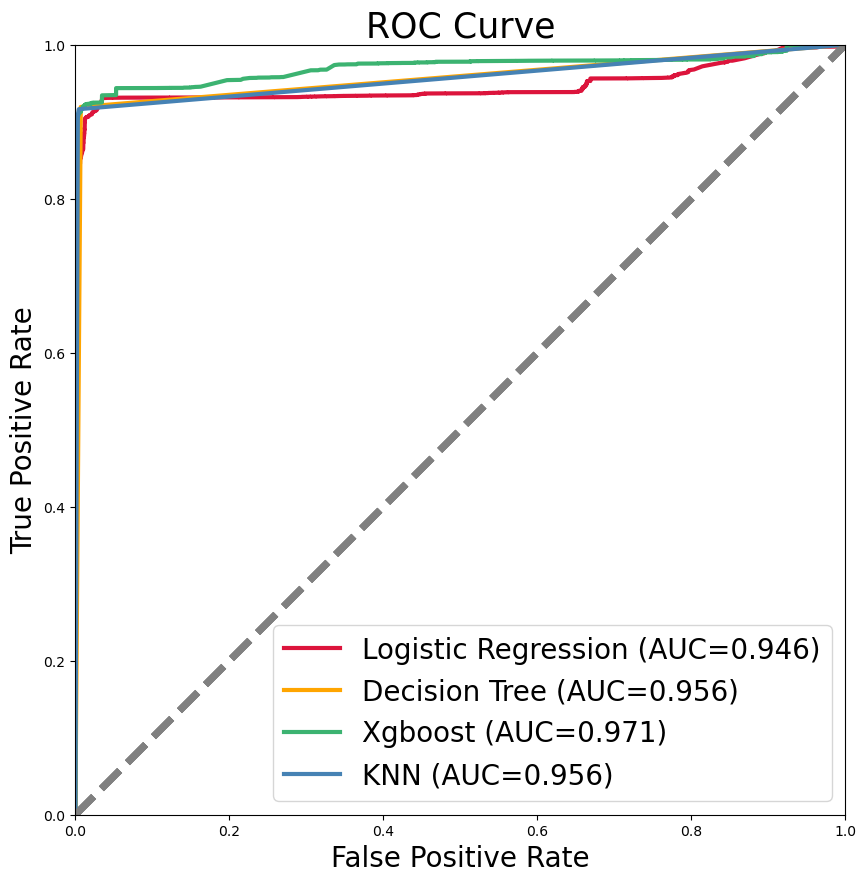

In [90]:
names = ['Logistic Regression','Decision Tree','Xgboost','KNN']
y_test_predprob=[y_test_lrprob,y_test_DTprob,y_test_xgbprob,y_test_knnprob]
colors = ['crimson','orange','mediumseagreen','steelblue']
#ROC curves
train_roc_graph = multi_models_roc(names, y_test_predprob, colors, Y_test,  save = True)
train_roc_graph.savefig('ROC_Train_all.png')
